## Preamble

In [4]:
import random

import numpy

from matplotlib import pyplot
from sklearn import linear_model

# The number of points to include in each (x, f(x)) series.

## "What's Lasso? (A convex optimization.)"

In [5]:
N = 100
rng = random.Random("Let's fool around with Lasso")
xs = numpy.array(list(sorted(rng.uniform(-3, 3) for _ in range(N)))).reshape(-1, 1)
ys = numpy.array([xi + rng.gauss(0, 0.4) for xi in xs]).reshape(-1, 1)

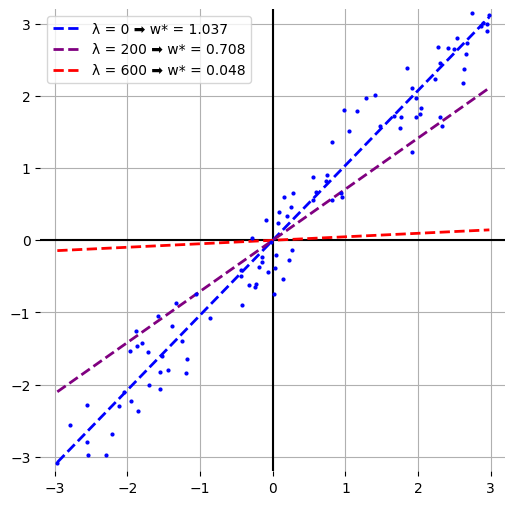

In [6]:
fig = pyplot.figure(figsize=(6, 6))
ax = fig.gca()
ax.axhline(color='k')
ax.axvline(color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

x_lims = [xs[0], xs[-1]]

colors = ['blue', 'purple', 'red']
alphas = [0.001, 1, 3]
for (color, alpha) in zip(colors, alphas):
    model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    model.fit(xs, ys)
    y_hats = model.predict(x_lims)
    label = f'λ = {alpha * 2 * N:0.0f} ➡️ w* = {model.coef_[0]:0.3f}'
    ax.plot(x_lims, y_hats, color=color, label=label,
            linestyle='--', linewidth=2)
ax.plot(xs, ys, 'b.', markersize=4)
ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-3.2, 3.2)
ax.grid()
ax.legend()

/home/bgawalt/venv/jupyter/lib/python3.10/site-packages/sklearn/base.py:1365: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/bgawalt/venv/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/bgawalt/venv/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.945e+00, tolerance: 3.404e-02
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mo

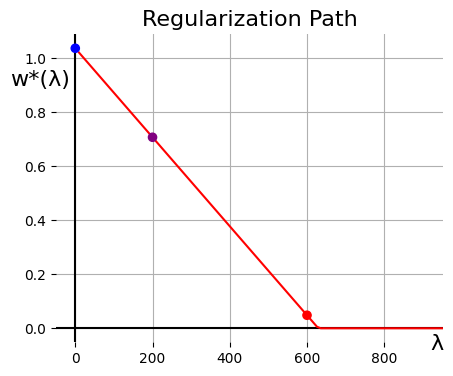

In [7]:
fig = pyplot.figure(figsize=(5, 4))
ax = fig.gca()
ax.axhline(color='k')
ax.axvline(color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

alpha = 0.001
coef = 1000
while coef > 1e-6:
    model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    model.fit(xs, ys)
    coef = model.coef_[0]
    #print(f'{alpha:0.3e}, {coef:0.3e}')
    alpha *= 1.25

coefs = []
alphas = []
for alpha in numpy.arange(alpha/100, alpha, alpha/100):
    model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    model.fit(xs, ys)
    coef = model.coef_[0]
    alphas.append(2 * N * alpha)
    coefs.append(coef)

special_lambdas = [0, 200, 600]
special_coefs = []
for lamb in special_lambdas:
    model = linear_model.Lasso(alpha=lamb/(2 * N), fit_intercept=False)
    model.fit(xs, ys)
    special_coefs.append(model.coef_[0])

ax.set_xlim(-50, 2 * N * alpha)
ax.text(2 * N * alpha, -0.02, 'λ', va='top', ha='right', fontsize=16)
ax.text(-14, 0.9, 'w*(λ)', ha='right', fontsize=16)
ax.set_title('Regularization Path', fontsize=16)


ax.scatter(special_lambdas, special_coefs, c=['blue', 'purple', 'red'], s=35, zorder=2.5)
ax.plot(alphas, coefs, 'r-', markersize=3)
ax.grid()
    
    

## "What's Lasso doing? (Parabolas.)

### "Zero regularization"

[array([1.03782033])] [array([13.88969475])]


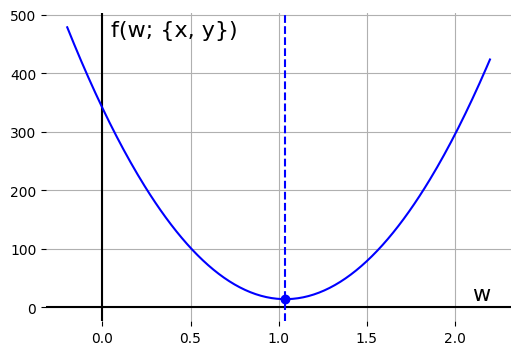

In [34]:
s_x = sum(xi * xi for xi in xs)
d_xy = sum(xi * yi for (xi, yi) in zip(xs, ys))
s_y = sum(yi * yi for yi in ys)

ws = numpy.arange(-0.2, 2.2, 0.01)
fs = [s_x * w * w - 2 * d_xy * w + s_y for w in ws]

fig = pyplot.figure(figsize=(6, 4))
ax = fig.gca()
ax.axhline(color='k')
ax.axvline(color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.plot(ws, fs, color='blue')
ax.scatter([d_xy/s_x,], [d_xy * d_xy / s_x - 2 * d_xy * d_xy / s_x + s_y],
           color='blue', s=37)
print([d_xy/s_x,], [d_xy * d_xy / s_x - 2 * d_xy * d_xy / s_x + s_y])
ax.text(2.2, 5, 'w', va='bottom', ha='right', fontsize=16)
ax.text(0.05, 490, 'f(w; {x, y})', ha='left', va='top', fontsize=16)
ax.axvline(x=(d_xy/s_x), color='blue', linestyle='--')
ax.grid()